In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
import os
import sys
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("recomm.txt", sep=" ",)

In [3]:
dataset.columns.get_values()

array(['movie', 'user', 'movie_ID', 'watch_flag'], dtype=object)

In [4]:
dataset.head()

,movie,user,movie_ID,watch_flag
0,...AND_JUSTICE_FOR_ALL,8220199100312385,42,1
1,...AND_JUSTICE_FOR_ALL,8499053340192848,42,0
2,...AND_JUSTICE_FOR_ALL,8497505080001762,42,0
3,...AND_JUSTICE_FOR_ALL,8771101090065695,42,0
4,...AND_JUSTICE_FOR_ALL,8498350064720676,42,0


In [5]:
len(dataset.user.unique()), len(dataset.movie_ID.unique())

(6292, 6082)

In [6]:
dataset.user = dataset.user.astype('category').cat.codes.values
dataset.movie_ID = dataset.movie_ID.astype('category').cat.codes.values

In [7]:
train, test = train_test_split(dataset, test_size=0.2)

In [8]:
train.head()

,movie,user,movie_ID,watch_flag
820992,THE_UNDEFEATED,6203,5474,1
327008,HOW_TO_BE_SINGLE,5426,2217,1
327386,HOW_TO_BUILD_A_BETTER_BOY,4221,2218,1
669853,THE_BOOK_OF_ELI,6250,4504,0
341719,IN_TIME,1325,2320,0


In [9]:
test.head()

,movie,user,movie_ID,watch_flag
709853,THE_GHOST_WRITER,54,4771,1
147968,CIRQUE_DU_FREAK__THE_VAMPIRE'S_ASSISTANT,2856,1025,1
540295,RAIDERS_OF_THE_LOST_ARK,6210,3619,0
833790,THERE'S_SOMETHING_ABOUT_MARY,6253,5567,0
415336,LOVE_HAPPENS,3790,2770,0


In [10]:
n_users, n_movies = len(dataset.user.unique()), len(dataset.movie_ID.unique())
n_latent_factors = 3

In [11]:
#ensuring GPU devices availability
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16393470070559434439, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13199361324707813751
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6916928273800342627
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15558138266
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 2056247794742728747
 physical_device_desc: "device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:07:00.0, compute capability: 7.0", name

In [12]:
from keras.utils.training_utils import multi_gpu_model
import tensorflow as tf

In [13]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

#prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
prod = keras.layers.dot([movie_vec, user_vec], axes=True)
model = keras.Model([user_input, movie_input], prod)

In [14]:
model = multi_gpu_model(model, gpus=4)
model.compile('adam', 'mean_squared_error')
#model.compile(loss='categorical_crossentropy',optimizer='rmsprop')

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         18249       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         18879       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [16]:
history = model.fit([train.user, train.movie_ID], train.watch_flag, batch_size=1000, epochs=500, verbose=0)

Text(0,0.5,'Train Error')

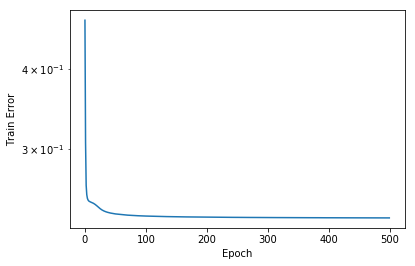

In [17]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [18]:
y_hat = np.round(model.predict([test.user, test.movie_ID]),0)
y_true = test.watch_flag

In [19]:
mean_absolute_error(y_true, y_hat)

0.5029772443737436

In [29]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,6083.000000,6083.000000,6083.000000
mean,0.405655,-0.421923,0.416441
std,0.425154,0.409823,0.415877
min,-1.827525,-2.458743,-2.239805
25%,0.174861,-0.649135,0.196199
50%,0.403922,-0.416645,0.423801
75%,0.626225,-0.205839,0.639170
max,2.602779,1.515718,2.269909


In [33]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,6293.000000,6293.000000,6293.000000
mean,0.391606,-0.400995,0.405487
std,0.605008,0.579727,0.590258
min,-3.575810,-4.113534,-3.674563
25%,0.134120,-0.637869,0.168137
50%,0.381284,-0.401228,0.409564
75%,0.632952,-0.165588,0.633634
max,4.412123,4.819306,5.081520


In [88]:
test1 = pd.DataFrame(test)
test1.index = range(0,183559)
test1 = test1.drop(['watch_flag'], axis=1)

In [89]:
predicted_target = pd.DataFrame(y_hat)
predicted_target.columns = ['predicted_to_watch']

In [90]:
final_dataset = pd.concat([test1, predicted_target], axis=1)
final_dataset

,movie,user,movie_ID,predicted_to_watch
0,THE_GHOST_WRITER,54,4771,1.0
1,CIRQUE_DU_FREAK__THE_VAMPIRE'S_ASSISTANT,2856,1025,1.0
2,RAIDERS_OF_THE_LOST_ARK,6210,3619,1.0
3,THERE'S_SOMETHING_ABOUT_MARY,6253,5567,1.0
4,LOVE_HAPPENS,3790,2770,0.0
5,STAR_TREK_INTO_DARKNESS,1799,4193,0.0
6,BRAVEHEART,1726,791,0.0
7,THE_HUSTLER,4589,4897,0.0
8,NEIGHBORS,852,3219,0.0
9,UNBROKEN,6179,5761,0.0
